<a href="https://colab.research.google.com/github/Vinnesta/l45-music-gnn/blob/main/L45_Mozart_is_a_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=green> Mozart is a GNN

Code Note:  
https://hackmd.io/@0Y_ZosHzSjKcz7sGAMMIXA/SyGTs-e6o/edit

## Environment set up

In [1]:
# For converting midi into wav files
# Make sure to install and import fluidsynth before everything else or it will error
!apt-get install fluidsynth
!pip install pyfluidsynth
import fluidsynth

# install packages
!pip install networkx mido pretty_midi

import torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils.convert import from_scipy_sparse_matrix

import mido
import pretty_midi
from scipy.io.wavfile import write

import numpy as np
import random

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


## Define Constants

In [2]:
NUM_NOTES = 128 # Number of notes specified by MIDI format

# Set the desired ticks per beat (tpb), where each beat is a quarter note
# `desired_tpb` determines the shortest note that will be captured (e.g. demisemiquavers/32nd-notes == 8 notes per beat)
# Need to double the desired "notes per beat" to account for the on/off of each note
desired_tpb = 8

## Functions for Processing MIDI

In [3]:
def read_midi(filename):
    file = mido.MidiFile(filename)
    msg_cnt = 0
    for i, track in enumerate(file.tracks):
        print('Track {}: {}'.format(i, track.name))
        for msg in track:
            print(msg)
# read_midi('example.midi')

def get_midi_length_in_seconds(filename):
    file = pretty_midi.PrettyMIDI(filename)
    length_in_seconds = file.get_end_time()
    return length_in_seconds

def get_midi_sample_rate(filename):
    s = get_midi_length_in_seconds(filename)
    t = get_midi_timesteps(filename)
    return int(t/s)

def get_midi_timesteps(filename):
    midi = mido.MidiFile(filename)
    timesteps = 0
    for track in midi.tracks:
        for msg in track:
            timesteps += msg.time
    return timesteps

TIMESTEPS = get_midi_timesteps("example.midi")
SECS = get_midi_length_in_seconds("example.midi")
SAMPLE_RATE = get_midi_sample_rate("example.midi")
print(TIMESTEPS, SECS, SAMPLE_RATE)

930262 969.0208333333334 960


In [4]:
# print the name of the instruments being played
def get_midi_instrument_types(filename):
    midi = pretty_midi.PrettyMIDI(filename)
    instrument_types = []
    for instrument in midi.instruments:
        # name of the instrument
        instrument_types.append(pretty_midi.program_to_instrument_name(instrument.program))
    return instrument_types

instrument_types = get_midi_instrument_types("example.midi")
print(instrument_types)

['Acoustic Grand Piano']


In [5]:
# what types of messages we get?
def print_midi_message_types(filename):
    midi = mido.MidiFile(filename)
    types = []
    for track in midi.tracks:
        for msg in track:
            if msg.type not in types:
                types.append(msg.type)
    return types

print_midi_message_types("example.midi")

['set_tempo',
 'time_signature',
 'end_of_track',
 'program_change',
 'control_change',
 'note_on']

In [6]:
def midi_to_tensor(filename, binary_velocity=False):
    mid = mido.MidiFile(filename)
    # Extract information about the notes being played
    max_timesteps = get_midi_timesteps(filename)
    tensor = np.zeros((max_timesteps, 128))
    previous_note = [0] * 128
    timesteps = 0
    for track in mid.tracks:
        for msg in track:
            timesteps += msg.time
            if msg.type == 'note_on':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                if binary_velocity:
                  tensor[timesteps, msg.note] = 1 if msg.velocity > 0 else 0
                else:
                  tensor[timesteps, msg.note] = msg.velocity
                previous_note[msg.note] = timesteps
            if msg.type == 'note_off':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                tensor[timesteps, msg.note] = 0
                previous_note[msg.note] = timesteps
    return torch.from_numpy(tensor)
midi_tensor = midi_to_tensor("example.midi")
print(midi_tensor.shape)

torch.Size([930262, 128])


In [7]:
def tensor_to_midi(tensor, filename, orig_tpb=384, binary_velocity=False):
    # Create a MIDI file
    mid = mido.MidiFile()
    mid.ticks_per_beat = orig_tpb
    track = mido.MidiTrack()
    mid.tracks.append(track)

    # Convert the tensor into messages
    current_timestep = 0
    for timestep in range(1,tensor.shape[0]):
        for note in range(0,128):
            if tensor[timestep, note] - tensor[timestep - 1, note] != 0:
                velocity = int(tensor[timestep, note])
                if binary_velocity:
                  velocity = velocity * 100
                msg = mido.Message('note_on', note=note, velocity=velocity, time=timestep-current_timestep)
                track.append(msg)
                current_timestep = timestep

    # Save the MIDI file
    mid.save(filename)
    return mid

#tensor_to_midi(midi_tensor[:93026],'test.midi')

In [8]:
def midi_to_wav(midi_filename, sf2_dir, wav_filename, sample_rate=44100):
    midi_data = pretty_midi.PrettyMIDI(midi_filename)
    audio_data = midi_data.fluidsynth(fs=44100, sf2_path = sf2_dir)
    #soundFontPickedFrom Fluid Release 3
    with open(wav_filename, 'wb') as f:
        write(f, sample_rate, audio_data)

midi_filename = "test.midi"
sf2_path = 'FluidR3_GM.sf2'
wav_filename = "test.wav"
#midi_to_wav(midi_filename, sf2_path, wav_filename)

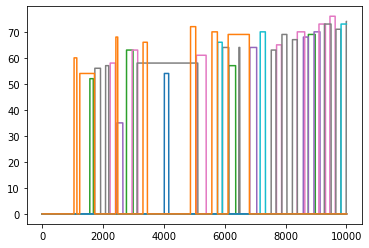

In [9]:
# Plot midi_tensor for notes in the central octave (C4 to B4) over time
plt.plot(midi_tensor.cpu().detach().numpy()[:10000, 60:72])
plt.show()

## Data Processing

In [10]:
#@title Functions to create Tonnetz adjacency matrix and edge attributes

# In Tonnetz, each node has six neighbours which have pitches of the following distances (in semi-tones)
# E.g. C4 has neighbours F3, G#3, A3, D#4, E4, G4
NEIGHBOUR_DISTANCES = [-7, -4, -3, 3, 4, 7]

def create_tonnetz_adjacency_matrix(num_notes):
  A = []

  for i in range(num_notes):
    row = torch.zeros(num_notes, dtype=torch.int)
    for d in NEIGHBOUR_DISTANCES:
      j = i+d
      if j >= 0 and j < num_notes:
        row[j] = 1
    A.append(row)
  return torch.stack(A)

def get_edge_attributes(A):
  # Returns edge attributes for the adjacency matrix `A`, 
  # where the edge attributes are a one-hot encoding for each type of edge
  edge_index = A.to_sparse().indices()
  edge_attr_raw = []
  for i in range(edge_index.shape[1]):
    distance = (edge_index[1][i] - edge_index[0][i]).item()
    edge_attr_raw.append(NEIGHBOUR_DISTANCES.index(distance))
  return F.one_hot(torch.tensor(edge_attr_raw))

A = create_tonnetz_adjacency_matrix(NUM_NOTES)

# Check that A is symmetric since the Tonnetz graph is undirected
assert(torch.equal(A, A.transpose(0, 1)))

In [19]:
#@title Functions to (un)compress and (un)reduce tensors

import math, logging

def calculate_compress_factor(file_name, desired_tpb):
  mid = mido.MidiFile(file_name)
  compress_factor = mid.ticks_per_beat / desired_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  return compress_factor

def compress_tensor(tensor, file_name, method, desired_tpb=16):
  '''
  Reduces the fidelity of the musical tensor, i.e. merge multiple timesteps into one step

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `file_name`: path to the MIDI file
    `method`: str in ["max", "avg", "majority"]
    `desired_tpb`: desired ticks per beat for the tensor to be compressed to
  '''
  tensor_np = tensor.cpu().detach().cpu()
  assert(len(tensor_np.shape) == 2)

  compress_factor = calculate_compress_factor(file_name, desired_tpb)
  compressed_vectors = []
  length = tensor_np.shape[0]
  for start in range(0, length, compress_factor):
    end = min(start + compress_factor, length)
    tensor_slice = tensor_np[start:end, :]
    if (method == "max"):
      raise NotImplementedError()
    elif (method == "avg"):
      raise NotImplementedError()
    elif (method == "majority"):
      majority = (end-start) / 2
      majority_nonzeroes = np.count_nonzero(tensor_slice, axis=0) >= majority
      compressed_vectors.append((majority_nonzeroes).astype(int))
    else:
      raise KeyError(f"Unknown method {method}")
  return torch.tensor(np.array(compressed_vectors))

def reduce_tensor(tensor, start_note, end_note):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: note to start the tensor from (integer in 0-127)
    `end_note`: note to end the tensor at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  return tensor[:, start_note:end_note+1]

def uncompress_tensor(tensor, orig_tpb, compressed_tpb):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `orig_tpb`: ticks per beat of the original/generated MIDI file
    `compressed_tpb`: ticks per beat used by the compressed `tensor`
  '''
  compress_factor = orig_tpb / compressed_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  # "Stretch" out the tensor using Kronecker product
  return torch.kron(tensor, torch.ones((compress_factor, 1)))

def unreduce_tensor(tensor, start_note, end_note):
  '''
  Expands out a reduced tensor to include all 128 notes in the MIDI range

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: MIDI note that `tensor` starts from (integer in 0-127)
    `end_note`: MIDI note that `tensor` ends at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  timesteps = tensor.shape[0]
  low_notes = torch.zeros((timesteps, start_note))
  high_notes = torch.zeros((timesteps, 127-end_note))
  return torch.cat((low_notes, tensor, high_notes), dim=1)

In [12]:
# function which takes music sequence and window size(history length) and return training data.
# music = Time_step x Num_nodes
def slice_temporal_data(music_seq,window_size=5):
  return [[torch.transpose(music_seq[i:i+window_size],0,1),music_seq[i+window_size].reshape(-1,1)] for i in range(len(music_seq)-window_size)]

### Generate test data

In [13]:
music_len = 100
time_steps = 5
number_nodes = 12

# generate toy music sequence and process it as traning data
toy_music = (torch.rand(music_len,number_nodes)<0.5).to(torch.float)
data = slice_temporal_data(toy_music,window_size=time_steps)
print("Input: ",data[0][0])
print("Output: ",data[0][1])

Input:  tensor([[0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]])
Output:  tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]])


In [14]:
# Toy adjacency matrix for testing
toy_adj_mat = (torch.rand(number_nodes,number_nodes)<0.5).to(torch.float)
print("Adjancy Matrix: ",toy_adj_mat)
print("Edge_index: ",toy_adj_mat.to_sparse())

toy_deg = torch.diag(torch.sum(toy_adj_mat, 1))
print("Degree Matrix: ",toy_deg)

Adjancy Matrix:  tensor([[0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.]])
Edge_index:  tensor(indices=tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,
                         2,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  4,  5,
                         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
                         6,  7,  

### Prepare dataset
May be need to do another batching methods. In current way, the node infmormation is separated, so that structural information is not well captured.

It should be;
- train_pred = model(X)[train_mask]
- train_label = label[train_mask]
- test_pred = model(X)[test_mask]
- test_label = label[test_mask]

In [15]:
# Download and extract piano MIDI files from Maestro
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip

import os
import zipfile
directory_to_extract_to = "maestro"
with zipfile.ZipFile("maestro-v3.0.0-midi.zip", 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

dir_to_scan = directory_to_extract_to + "/maestro-v3.0.0/2013"
directory_files = os.listdir(dir_to_scan)
data_files = []
for file in directory_files:
  data_files.append(os.path.join(dir_to_scan, file))

--2023-03-14 16:04:40--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.251.111.128, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip.1’

maestro-v3.0.0-midi 100%[===================>]  55.71M  48.8MB/s    in 1.1s    

2023-03-14 16:04:41 (48.8 MB/s) - ‘maestro-v3.0.0-midi.zip.1’ saved [58416533/58416533]



In [20]:
num_files = 10
window_size = desired_tpb * 4
start_note = 33
end_note = 96

train_data = []
for i, data_file in enumerate(data_files):
  midi_tensor = midi_to_tensor(data_file, binary_velocity=True)
  compressed_tensor = compress_tensor(midi_tensor, data_file, "majority", desired_tpb)
  reduced_tensor = reduce_tensor(compressed_tensor, start_note, end_note)
  train_data += slice_temporal_data(reduced_tensor.to(torch.float), window_size)
  if i == num_files:
    break
print(len(train_data), train_data[0][0].shape, train_data[0][1].shape)

64930 torch.Size([64, 32]) torch.Size([64, 1])


In [21]:
new_num_notes = train_data[0][0].shape[0]
A = create_tonnetz_adjacency_matrix(new_num_notes)
edge_attr = get_edge_attributes(A)

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_X = torch.stack([d[0] for d in train_data])
print(data_X.shape)
y = torch.stack([d[1] for d in train_data])
data_Y = y.squeeze(-1)
'''
To create a multi-class label:

data_Y = np.zeros((y.shape[0],y.shape[1],2))
for i,nodes in enumerate(y):
  for j,node in enumerate(nodes):
    data_Y[i][j][int(node)] = 1.0
data_Y = torch.tensor(data_Y)
'''
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([64930, 64, 32])
torch.Size([51944, 64, 32])
torch.Size([51944, 64])


In [23]:
def train_eval(net, criterion, optimizer, epoch, train_dataloader, valid_dataloader=None, epochs_to_report=10):
  '''
  `epochs_to_report`: the number of epochs before reporting progress
  '''

  train_loss_list = []
  train_acc_list = []
  test_loss_list = []
  test_acc_list = []

  for i in range(epoch):
      report_progress = (i+1) % epochs_to_report == 0
      if report_progress:
        print("\n------------------------------------------------------")
        print("Epoch {}/{}".format(i+1,epoch))
      
      train_loss = 0
      train_acc = 0
      test_loss = 0
      test_acc = 0
      
      net.train()
      for data,label in train_dataloader:
          data = data.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred_prob = net(data)
          loss = criterion(y_pred_prob,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          y_pred = torch.round(torch.sigmoid(y_pred_prob))
          train_acc += torch.count_nonzero(torch.all(torch.eq(label, y_pred), dim=1)).item() / len(label)
      batch_train_loss = train_loss/len(train_dataloader)
      batch_train_acc = train_acc/len(train_dataloader)
      train_loss_list.append(batch_train_loss)
      train_acc_list.append(batch_train_acc)
      if report_progress:
        print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
      
      if valid_dataloader is not None:
        net.eval()
        with torch.no_grad():
            for data,label in valid_dataloader:
                data = data.to(device)
                label = label.to(device)
                y_pred_prob = net(data)
                loss = criterion(y_pred_prob,label)
                test_loss += loss.item()
                y_pred = torch.round(torch.sigmoid(y_pred_prob))
                test_acc += torch.count_nonzero(torch.all(torch.eq(label, y_pred), dim=1)).item() / len(label)
        batch_test_loss = test_loss/len(valid_dataloader)
        batch_test_acc = test_acc/len(valid_dataloader)
        test_loss_list.append(batch_test_loss)
        test_acc_list.append(batch_test_acc)
        if report_progress:
          print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

  # visualizing training process
  plt.figure()
  plt.title("Train and Test Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
  if valid_dataloader is not None:
    plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
  plt.legend()
  plt.figure()
  plt.title("Train and Test Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
  if valid_dataloader is not None:
    plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
  plt.legend()
  plt.show()

## Model architecture examples

In [24]:
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_geometric.nn import GCNConv, MessagePassing
from torch_scatter import scatter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Simple MLP Model

In [ ]:
class SimpleMLP(nn.Module):
    # input_dim = dim of node features
    def __init__(self, input_dim, hidden_dim=16):
      super(SimpleMLP, self).__init__()
      self.linear1 = nn.Linear(input_dim, hidden_dim)
      self.linear2 = nn.Linear(hidden_dim, hidden_dim)
      self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
      x = self.linear1(x)
      x = self.linear2(x)
      y_hat = self.linear3(x)
      y_hat = y_hat.squeeze(-1)
      return y_hat


------------------------------------------------------
Epoch 5/10
Train_Loss: 0.1963 Train_Acc: 0.3864
Test_Loss: 0.1967 Test_Acc: 0.3702

------------------------------------------------------
Epoch 10/10
Train_Loss: 0.1960 Train_Acc: 0.3871
Test_Loss: 0.1967 Test_Acc: 0.4062


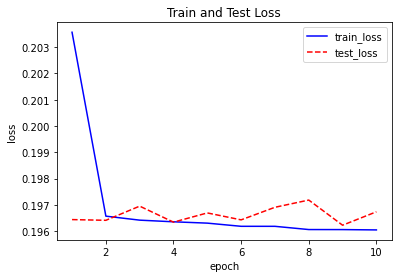

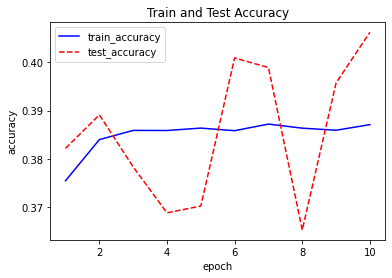

In [27]:
net = SimpleMLP(window_size).to(device)
pos_weight = torch.ones([new_num_notes]) * 5
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
epoch = 10
train_eval(net, criterion, optimizer, epoch, train_dataloader, valid_dataloader, epochs_to_report=5)

### Multilayer GCN

In [28]:
class MultiGCN(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim=8, output_dim=2):
        super(MultiGCN, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        
        # GCN layers
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn_conv1 = GCNConv(hidden_dim,hidden_dim, improved=True)
        self.gcn_conv2 = GCNConv(hidden_dim,hidden_dim, improved=False)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.gcn_conv1(x,self.edge_index))
        x = F.relu(self.gcn_conv2(x,self.edge_index))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        y_hat = x.squeeze(-1)
        return y_hat


------------------------------------------------------
Epoch 5/10
Train_Loss: 0.1864 Train_Acc: 0.3492

------------------------------------------------------
Epoch 10/10
Train_Loss: 0.1846 Train_Acc: 0.3530


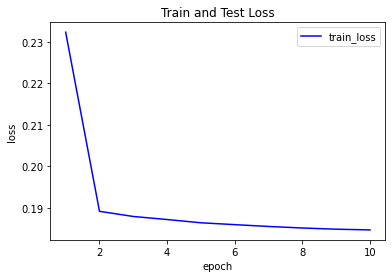

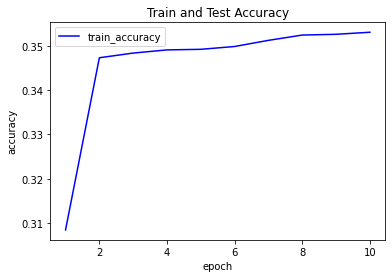

In [29]:
net = MultiGCN(A, window_size, output_dim=1).to(device)
pos_weight = torch.ones([new_num_notes]) * 5
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
epoch = 10

train_eval(net, criterion, optimizer, epoch, train_dataloader, valid_dataloader=None, epochs_to_report=5)

### Message Passing Neural Network (MPNN)

In [30]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=6, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim

        # MLP `\psi` for computing messages `m_ij`
        # dims: (2d + d_e) -> d
        #self.mlp_msg = Sequential(
        #    Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
        #    Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
        #  )
        self.mlp_msg = Sequential(Linear(2*emb_dim + edge_dim, emb_dim), ReLU(), Linear(emb_dim, emb_dim), ReLU())
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        #self.mlp_upd = Sequential(
        #    Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
        #    Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
        #  )
        self.mlp_upd = Sequential(Linear(2*emb_dim, emb_dim), ReLU(), Linear(emb_dim, emb_dim), ReLU())

    def forward(self, h, edge_index, edge_attr):
        """
        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """
        Args:
            h_i: (e, d) - destination node features, essentially h[edge_index[0]]
            h_j: (e, d) - source node features, essentially h[edge_index[1]]
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        if len(h_i.shape) == 3:
          # First dimension is batch size, repeat (i.e. tile) edge_attr
          edge_attr = edge_attr.repeat(h_i.shape[0], 1, 1)
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """
        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

class MPNNModel(nn.Module):
  def __init__(self, A, edge_attr, in_dim, num_layers=4, emb_dim=64, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            in_dim: (int) - initial node feature dimension `d_n`
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        self.edge_index = A.to_sparse().indices().to(device)
        self.edge_attr = edge_attr
        self.edge_dim = self.edge_attr.shape[1]

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in1 = Linear(in_dim, emb_dim)
        self.lin_in2 = Linear(emb_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, self.edge_dim, aggr='add'))

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred1 = Linear(emb_dim, emb_dim)
        self.lin_pred2 = Linear(emb_dim, out_dim)
        
  def forward(self, x):
      """
      Args:
          data: (PyG.Data) - batch of PyG graphs

      Returns: 
          out: (batch_size, out_dim) - prediction for each graph
      """
      h = F.relu(self.lin_in1(x))
      h = F.relu(self.lin_in2(h))
      
      for conv in self.convs:
          #h = h + conv(h, self.edge_index)
          h = conv(h, self.edge_index, self.edge_attr)

      h = F.relu(self.lin_pred1(h))
      out = self.lin_pred2(h)
      return out.squeeze(-1)


------------------------------------------------------
Epoch 2/10
Train_Loss: 0.1223 Train_Acc: 0.4200
Test_Loss: 0.1217 Test_Acc: 0.4188

------------------------------------------------------
Epoch 4/10
Train_Loss: 0.1198 Train_Acc: 0.4222
Test_Loss: 0.1199 Test_Acc: 0.4306

------------------------------------------------------
Epoch 6/10
Train_Loss: 0.1190 Train_Acc: 0.4237
Test_Loss: 0.1193 Test_Acc: 0.4315

------------------------------------------------------
Epoch 8/10
Train_Loss: 0.1184 Train_Acc: 0.4245
Test_Loss: 0.1189 Test_Acc: 0.4245

------------------------------------------------------
Epoch 10/10
Train_Loss: 0.1176 Train_Acc: 0.4255
Test_Loss: 0.1222 Test_Acc: 0.4308


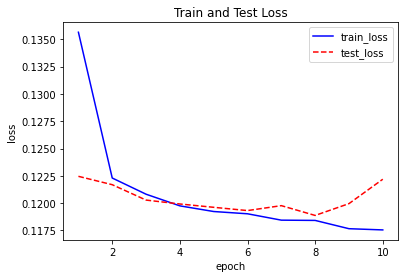

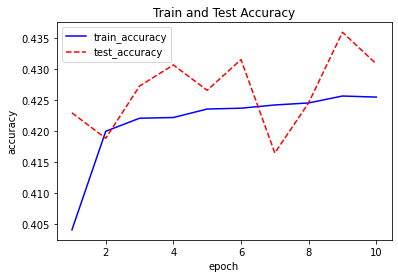

In [31]:
mpnn_net = MPNNModel(A, edge_attr, in_dim=window_size, num_layers=4, emb_dim=32, out_dim=1).to(device)
pos_weight = torch.ones([new_num_notes]) * 3
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(mpnn_net.parameters(), lr=0.005)
epoch = 10

train_eval(mpnn_net, criterion, optimizer, epoch, train_dataloader, valid_dataloader, epochs_to_report=2)

## Music Generation

In [ ]:
#@title Functions to generate music tensors from a model and save as a Wav file

def generate_music_tensor(net, seed, timesteps):
  generated = seed
  window_size = seed.shape[1]
  for i in range(timesteps):
    if i == 0:
      pred = net(seed)
    else:
      pred = net(generated[:, -window_size:])
    curr = (torch.sigmoid(pred) > 0.5).float()
    generated = torch.cat((generated, curr.unsqueeze(1)), dim=1)
  return generated

def create_music(model, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb, sf2_path):
  generated_tensor = generate_music_tensor(model, seed, new_timesteps)
  generated_tensor_mod = unreduce_tensor(torch.transpose(generated_tensor, 0, 1), start_note, end_note)
  generated_tensor_mod = uncompress_tensor(generated_tensor_mod, orig_tpb, compressed_tpb)

  time_now = datetime.now().strftime("%Y%m%dT%H%M%S")
  generated_file_name = f"GNN_Generated_Song_{time_now}"
  midi_filename = f'{generated_file_name}.midi'
  wav_filename = f'{generated_file_name}.wav'

  mid = tensor_to_midi(generated_tensor_mod, midi_filename, orig_tpb, binary_velocity=True)
  midi_to_wav(midi_filename, sf2_path, wav_filename)
  return generated_tensor

In [ ]:
new_timesteps = 256
orig_tpb = 384
compressed_tpb = desired_tpb
sf2_path = '/content/drive/MyDrive/L45/FluidR3_GM.sf2'

data, _ = next(iter(valid_dataloader))
seed = data[0]
generated = create_music(mpnn_net, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb, sf2_path)
print(generated.shape)
plt.plot(torch.transpose(generated, 0, 1).cpu().detach().numpy())
plt.show()